In [1]:
import numpy as np
from numpy import float32
import warnings
import os
import sys
import glob
import tensorflow as tf
import cv2
from sklearn import utils
from sklearn import preprocessing
import matplotlib.pyplot as plt
import Augmentor
from pathlib import Path

import tensorflow.keras.backend as K
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import *
from tensorflow.keras.utils import *
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

sys.path.append(os.path.join(Path.cwd(), 'utils'))

from utils.im_utils import *
from utils.resnet_model import *

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
FLARE_CLASS = 'B'

TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_data/train'
VAL_DATA_DIR = f'./data/{FLARE_CLASS}_data/val'
TEST_DATA_DIR = f'./data/{FLARE_CLASS}_data/test'

AUG_TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_data_augmented/train'
AUG_VAL_DATA_DIR = f'./data/{FLARE_CLASS}_data_augmented/val'
AUG_TEST_DATA_DIR = f'./data/{FLARE_CLASS}_data_augmented/test'

RESNET_CHECKPOINTS_DIR = './checkpoints/resnet_checkpoints'

In [4]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [5]:
def augment_train_data():
    delete_files(f'{AUG_TRAIN_DATA_DIR}/positive')
    delete_files(f'{AUG_TRAIN_DATA_DIR}/negative')
    
    for subdir, dirs, files in os.walk(TRAIN_DATA_DIR):
        for file in files:
            filepath = os.path.join(subdir, file)
            img = np.load(filepath)
            # rotated_imgs = [rotate_img(img, 90), rotate_img(img, 180), rotate_img(img, 270)]
            # for idx, rot_img in enumerate(rotated_imgs):
            #     rotated_img_save = os.path.join(subdir, f'{file}_{idx}_rot')
            #     np.save(rotated_img_save, rot_img)

            fliplr_img = np.fliplr(img)
            flipud_img = np.flipud(img)
            rot90_img = np.rot90(img)
            rot180_img = np.rot90(img, 2)
            rot270_img = np.rot90(img, 3)
            
            folder = subdir.rsplit('/', 1)[1]
            cut_filename = file.rsplit('.', 1)[0]

            original_img_save = os.path.join(f'{AUG_TRAIN_DATA_DIR}/{folder}', cut_filename)
            fliplr_img_save = os.path.join(f'{AUG_TRAIN_DATA_DIR}/{folder}', f'{cut_filename}_fliplr')
            flipud_img_save = os.path.join(f'{AUG_TRAIN_DATA_DIR}/{folder}', f'{cut_filename}_flipud')
            rot90_img_save = os.path.join(f'{AUG_TRAIN_DATA_DIR}/{folder}', f'{cut_filename}_rot90')
            rot180_img_save = os.path.join(f'{AUG_TRAIN_DATA_DIR}/{folder}', f'{cut_filename}_rot180')
            rot270_img_save = os.path.join(f'{AUG_TRAIN_DATA_DIR}/{folder}', f'{cut_filename}_rot270')

            np.save(original_img_save, img)
            np.save(fliplr_img_save, fliplr_img)
            np.save(flipud_img_save, flipud_img)
            np.save(rot90_img_save, rot90_img)
            np.save(rot180_img_save, rot180_img)
            np.save(rot270_img_save, rot270_img)

            # translated_img = translate(img)
            # translated_img_save = os.path.join(subdir, f'{file}_trans')
            # np.save(translated_img_save, translated_img)

In [6]:
# augment_train_data()

In [7]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, files_paths,
                 batch_size,
                 input_size=(128, 128, 1),
                 shuffle=True):
        
        self.files_paths = files_paths.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.files_paths)
        self.n_category = 2
        # self.n_name = df[y_col['name']].nunique()
        # self.n_type = df[y_col['type']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.files_paths)
    
    def __getitem__(self, index):
        batches = self.files_paths[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __get_input(self, path):
        # image = preprocessing.normalize(np.load(path))
        image = np.load(path)
        # image = NormalizeData(image)
        image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_AREA)
        # image = preprocessing.normalize(image)
        return image

    def __get_output(self, path, num_classes=2):
        label = None
        folder = path.rsplit('/')[-2]
        if folder == 'positive':
            label = 1
        elif folder == 'negative':
            label = 0
        
        return label
        # return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        # path_batch = batches[self.X_col['path']]
        # category_batch = batches[self.y_col['type']]

        X_batch = np.asarray([self.__get_input(x) for x in batches])
        y_batch = np.asarray([self.__get_output(y, self.n_category) for y in batches])

        return X_batch, y_batch

In [8]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
  
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [9]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
   
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [10]:
def ResNet50(include_top=True, weights=None,
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=2):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    #if weights == 'imagenet' and include_top and classes != 15:
    #    raise ValueError('If using `weights` as imagenet with `include_top`'
    #                     ' as true, `classes` should be 15')

    # Determine proper input shape
    
    # input_shape = _obtain_input_shape(input_shape,
    #                                   default_size=256,
    #                                   min_size=197,
    #                                   data_format=K.image_data_format(),
    #                                   require_flatten=include_top)
    
    input_shape = (128, 128, 1)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
            
    print(K.image_data_format())
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((4, 4), name='avg_pool')(x)
    x = Dropout(0.4)(x)

    if include_top:
        x = GlobalAveragePooling2D()(x)
        # x = Flatten()(x)
        x = Dense(1, activation='sigmoid', name='fc2')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model

In [11]:
train_files = []
for subdir, dirs, files in os.walk(AUG_TRAIN_DATA_DIR):
     for f in files:
        train_files.append(os.path.join(subdir, f))
train_files = np.array(train_files)

val_files = []
for subdir, dirs, files in os.walk(AUG_VAL_DATA_DIR):
     for f in files:
        val_files.append(os.path.join(subdir, f))
val_files = np.array(val_files)

test_files = []
for subdir, dirs, files in os.walk(AUG_TEST_DATA_DIR):
     for f in files:
        test_files.append(os.path.join(subdir, f))
test_files = np.array(test_files)

In [12]:
batch_size = 128
traingen = CustomDataGen(train_files, batch_size)
valgen = CustomDataGen(val_files, batch_size)

In [13]:
epochs = 30
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
adam_fine = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, decay=0.0002, amsgrad=False)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [20]:
model = ResNet50(include_top=True)
# model.compile(loss='binary_crossentropy', optimizer=adam_fine, metrics=['accuracy'])

# history = model.fit(traingen, validation_data = valgen, epochs=epochs)

channels_last


In [22]:
model.load_weights(f'{RESNET_CHECKPOINTS_DIR}/adam_newdata_B_class__5e-5_checkpoint')

In [23]:
t = np.load('./data/B_data/train/positive/AIA20160101_0442_0094_0.npy')
t = cv2.resize(t, (128, 128), interpolation = cv2.INTER_AREA)
t = np.array([t.reshape(128, 128, 1)]) 

In [24]:
model.predict(t)

1/1 [==============================] - 1s 1s/step


array([[0.9999975]], dtype=float32)

In [17]:
model.save_weights(f'{RESNET_CHECKPOINTS_DIR}/adam_newdata_B_class__5e-5_checkpoint')

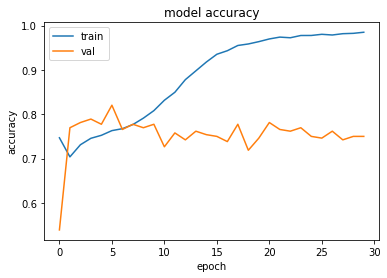

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

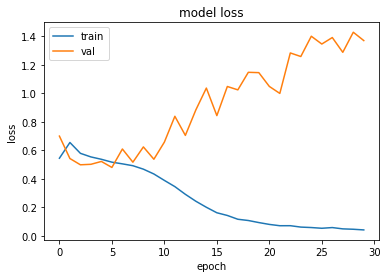

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()